# Wavelet CNN for Texture Classification

**Author:** [Tarun R Jain](https://twitter.com/TRJ_0751)<br>
**Date created:** 2022/11/13<br>
**Last modified:** 2022/11/13<br>
**Description:** Implement Multiresolution Analysis via Wavelet Transform.

## Introduction

This paper is a novel CNN architecture, **Wavelet CNNs**, which combines a multiresolution analysis and CNNs into one model. The researcher's insight is that a CNN can be viewed as a limited form of a MultiResolution Analysis. Based on this insight, they supplement missing parts of the multiresolution analysis via **Wavelet transform** and integrate them as additional components in the entire architecture. Wavelet CNNs allow us to utilize spectral information which is mostly lost in conventional CNNs but useful in most image processing tasks. We evaluate the practical performance of wavelet CNNs on texture classification and image annotation. The notebool show that wavelet CNNs can achieve better accuracy in both tasks than existing models while having significantly fewer parameters than conventional CNNs.

![wavelet_cnn](https://raw.githubusercontent.com/menon92/WaveletCNN/master/wavelet-cnn.png "wavelet")

#### Reference: [https://arxiv.org/pdf/1805.08620.pdf](https://arxiv.org/pdf/1805.08620.pdf)

## Setup

In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
import shutil
from sklearn.model_selection import ShuffleSplit
from tqdm import tqdm

import tensorflow as tf
from tensorflow import keras
from keras import models,layers
from keras.preprocessing.image import ImageDataGenerator
from keras import backend

## Define the Hyperparameters

In [46]:
ROOT_DIR = os.path.join("kth_tips_col_200x200","KTH_TIPS")
TRAIN_DIR = "./training"
TEST_DIR = "./testing"
BATCH_SIZE = 16
EPOCHS = 10
NUM_CLASSES = len(os.listdir(ROOT_DIR))-1 #-1 because the data contains readme.txt
INPUT_SHAPE = (224, 224, 3)
CLASS_MODE = 'categorical'

## Prepare the Data

In [4]:
#create training and testing directory if it doesn't exist
for path in [TRAIN_DIR,TEST_DIR]:
    if not os.path.exists(path):
        os.mkdir(path)
        
#Create subfolders with the class names as the directory name
for subfolder in os.listdir(ROOT_DIR):
    #since we need only directory, we need to exclude README.txt
    if subfolder == 'README.txt':
        pass
    else:
        if not os.path.exists(os.path.join(TRAIN_DIR,subfolder)):
            os.mkdir(os.path.join(TRAIN_DIR,subfolder))

        if not os.path.exists(os.path.join(TEST_DIR, subfolder)):
            os.mkdir(os.path.join(TEST_DIR, subfolder))

In [5]:
data = {}
for target in os.listdir(ROOT_DIR):
    if target == "README.txt":
        pass
    else:
        for img in os.listdir(os.path.join(ROOT_DIR,target)):
            data.update({os.path.join(ROOT_DIR,target,img):target})

In [6]:
print(len(data)) # we have 10 classes each class has 81 images

810


In [7]:
# create a Pandas Series for the all images in the dataset
X = pd.Series(data.keys())
#one hot encoding for the target labels
y = pd.get_dummies(data.values())

In [8]:
split = ShuffleSplit(n_splits=1,test_size=0.25,train_size=0.75,random_state=42)

In [9]:
for train_idx, test_idx in split.split(X, y):
    train_paths = X[train_idx]
    test_paths = X[test_idx]

    # define a new path for each image depending on training or testing
    new_train_paths = [re.sub(ROOT_DIR, './training', i) for i in train_paths]
    new_test_paths = [re.sub(ROOT_DIR, './testing/', i) for i in test_paths]

    train_path_map = list((zip(train_paths, new_train_paths)))
    test_path_map = list((zip(test_paths, new_test_paths)))
    
    # Move image into training and testing directory
    print("Move training images..")
    for i in tqdm(train_path_map):
        if not os.path.exists(i[1]):
            if not os.path.exists(re.sub('training', 'testing', i[1])):
                shutil.copy(i[0], i[1])
    
    print("Move testing images..")
    for i in tqdm(test_path_map):
        if not os.path.exists(i[1]):
            if not os.path.exists(re.sub('training', 'testing', i[1])):
                shutil.copy(i[0], i[1])

Move training images..


100%|█████████████████████████████████████| 607/607 [00:00<00:00, 133142.06it/s]


Move testing images..


100%|█████████████████████████████████████| 203/203 [00:00<00:00, 119249.82it/s]


In [10]:
train_aug = ImageDataGenerator(rescale = 1/255.0,
                               rotation_range = 45,
                               zoom_range = 0.2,
                               horizontal_flip = True)

In [11]:
test_aug = ImageDataGenerator(rescale = 1/255.0)

In [12]:
training_data = train_aug.flow_from_directory(TRAIN_DIR,
                                              class_mode=CLASS_MODE,
                                              batch_size=BATCH_SIZE,
                                              target_size=INPUT_SHAPE[:2])

Found 607 images belonging to 10 classes.


In [13]:
testing_data = test_aug.flow_from_directory(TEST_DIR,
                                            class_mode=CLASS_MODE,
                                            batch_size=BATCH_SIZE,
                                            target_size=INPUT_SHAPE[:2])

Found 203 images belonging to 10 classes.


## Visualize the Data

In [14]:
def plot_data(DIR):
    plt.figure(figsize=(15,10))
    for i in range(12):
        # we need to plot 12 images as a sample
        plt.subplot(3,4,i+1)
        #the training and testing data contains the image and label in form of tuple
        valid_images,valid_labels = DIR[i]
        plt.imshow(valid_images[0])
        #label is in one-hot-encoder format and it needs to be decoded
        decode_label = np.argmax(valid_labels) 
        plt.title(decode_label)
        plt.axis("off")

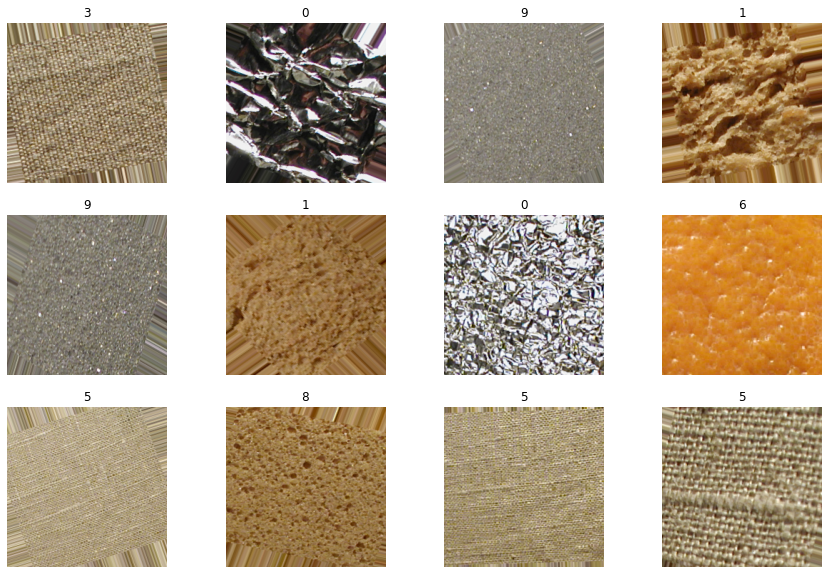

In [15]:
plot_data(training_data)

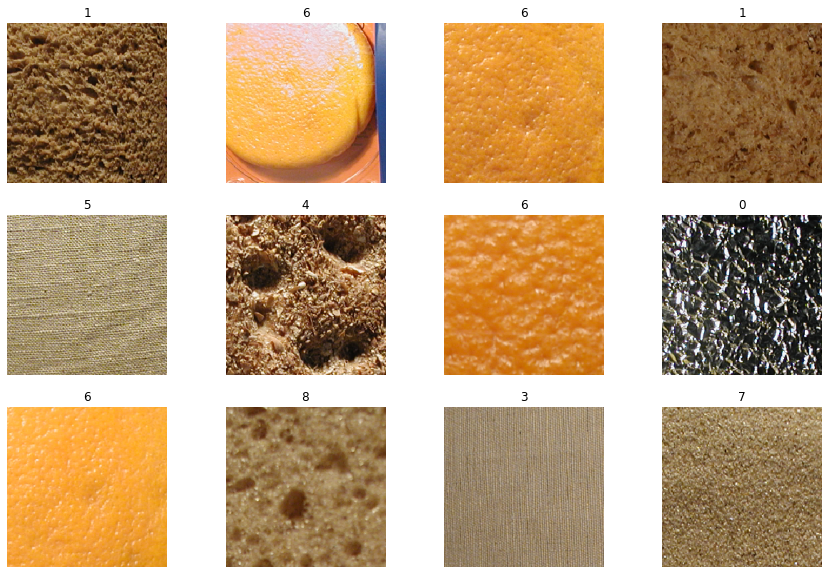

In [16]:
plot_data(testing_data)

## Define Wavelet Transform

In [17]:
# create batch operations for Wavelet transform through Y axis
def WaveletTransformAxisY(batch):
    odd  = batch[:,0::2]
    even = batch[:,1::2]
    lpf = (odd + even) / 2.0
    hpf = backend.abs(odd - even)
    return lpf,hpf

In [18]:
# create batch operations for Wavelet transform through X axis
def WaveletTransformAxisX(batch):
    net = backend.permute_dimensions(batch, [0, 2, 1])[:,:,::-1]
    lpf, hpf = WaveletTransformAxisY(net)
    k_l = backend.permute_dimensions(lpf, [0, 2, 1])[:,::-1,...]
    k_h = backend.permute_dimensions(hpf, [0, 2, 1])[:,::-1,...]
    return k_l, k_h

In [19]:
def Wavelet(batch):
    # define the image channels = RGB
    batch_image = backend.permute_dimensions(batch, [0, 3, 1, 2])
    r = batch_image[:,0]
    g = batch_image[:,1]
    b = batch_image[:,2]
    
    """
    According to the architecture we totally have 4 divisions of low pass and high pass filter
    i.e., kh1, kh2, kh3, kh4, kl1, kl2, kl3, kl4
    and all these filters are applied on the each rgb channel, the second divison follows first division,
    third division follow second and so on...
    """
    # now define the wavelet of low pass filter and high pass filter for each channel
    
    # wavelet division- 1
    # red channel
    wavelet_low_pass1, wavelet_high_pass1 = WaveletTransformAxisY(r)
    red_wavelet_low_low, red_wavelet_low_high = WaveletTransformAxisX(wavelet_low_pass1)
    red_wavelet_high_low, red_wavelet_high_high = WaveletTransformAxisX(wavelet_high_pass1)

    # green channel
    wavelet_low_pass1, wavelet_high_pass1 = WaveletTransformAxisY(g)
    green_wavelet_low_low, green_wavelet_low_high  = WaveletTransformAxisX(wavelet_low_pass1)
    green_wavelet_high_low, green_wavelet_high_high = WaveletTransformAxisX(wavelet_high_pass1)

    # blue channel
    wavelet_low_pass1, wavelet_high_pass1 = WaveletTransformAxisY(b)
    blue_wavelet_low_low, blue_wavelet_low_high  = WaveletTransformAxisX(wavelet_low_pass1)
    blue_wavelet_high_low, blue_wavelet_high_high = WaveletTransformAxisX(wavelet_high_pass1)

    division1 = [red_wavelet_low_low,red_wavelet_low_high,red_wavelet_high_low,red_wavelet_high_high, 
                    green_wavelet_low_low, green_wavelet_low_high, green_wavelet_high_low, green_wavelet_high_high,
                    blue_wavelet_low_low,blue_wavelet_low_high,blue_wavelet_high_low,blue_wavelet_high_high]
    
    wavelet1 = backend.stack(division1, axis=1)

    # wavelet divison -2
    wavelet_low_pass2, wavelet_high_pass2 = WaveletTransformAxisY(red_wavelet_low_low)
    red_wavelet_low_low2, red_wavelet_low_high2 = WaveletTransformAxisX(wavelet_low_pass2)
    red_wavelet_high_low2, red_wavelet_high_high2 = WaveletTransformAxisX(wavelet_high_pass2)

    wavelet_low_pass2, wavelet_high_pass2 = WaveletTransformAxisY(green_wavelet_low_low)
    green_wavelet_low_low2, green_wavelet_low_high2 = WaveletTransformAxisX(wavelet_low_pass2)
    green_wavelet_high_low2, green_wavelet_high_high2 = WaveletTransformAxisX(wavelet_high_pass2)

    wavelet_low_pass2, wavelet_high_pass2 = WaveletTransformAxisY(blue_wavelet_low_low)
    blue_wavelet_low_low2, blue_wavelet_low_high2 = WaveletTransformAxisX(wavelet_low_pass2)
    blue_wavelet_high_low2, blue_wavelet_high_high2 = WaveletTransformAxisX(wavelet_high_pass2)


    division2 = [red_wavelet_low_low2,red_wavelet_low_high2,red_wavelet_high_low2,red_wavelet_high_high2,
                green_wavelet_low_low2,green_wavelet_low_high2,green_wavelet_high_low2,green_wavelet_high_high2,
                blue_wavelet_low_low2,blue_wavelet_low_high2,blue_wavelet_high_low2,blue_wavelet_high_high2]
    wavelet2 = backend.stack(division2, axis=1)

    # wavelet divison -3
    wavelet_low_pass3, wavelet_high_pass3 = WaveletTransformAxisY(red_wavelet_low_low2)
    red_wavelet_low_low3, red_wavelet_low_high3 = WaveletTransformAxisX(wavelet_low_pass3)
    red_wavelet_high_low3, red_wavelet_high_high3 = WaveletTransformAxisX(wavelet_high_pass3)

    wavelet_low_pass3, wavelet_high_pass3 = WaveletTransformAxisY(green_wavelet_low_low2)
    green_wavelet_low_low3, green_wavelet_low_high3 = WaveletTransformAxisX(wavelet_low_pass3)
    green_wavelet_high_loss3, green_wavelet_high_high3 = WaveletTransformAxisX(wavelet_high_pass3)

    wavelet_low_pass3, wavelet_high_pass3 = WaveletTransformAxisY(blue_wavelet_low_low2)
    blue_wavelet_ll3, blue_wavelet_lh3 = WaveletTransformAxisX(wavelet_low_pass3)
    blue_wavelet_hl3, blue_wavelet_hh3 = WaveletTransformAxisX(wavelet_high_pass3)

    division3 = [red_wavelet_low_low3, red_wavelet_low_high3, red_wavelet_high_low3, red_wavelet_high_high3, 
                    green_wavelet_low_low3, green_wavelet_low_high3, green_wavelet_high_loss3, green_wavelet_high_high3,
                    blue_wavelet_ll3, blue_wavelet_lh3, blue_wavelet_hl3, blue_wavelet_hh3]
    wavelet3 = backend.stack(division3, axis=1)

    # wavelet divison -4
    wavelet_low_pass4, wavelet_high_pass4 = WaveletTransformAxisY(red_wavelet_low_low3)
    red_wavelet_ll4, red_wavelet_lh4 = WaveletTransformAxisX(wavelet_low_pass4)
    red_wavelet_hl4, red_wavelet_hh4 = WaveletTransformAxisX(wavelet_high_pass4)

    wavelet_low_pass4, wavelet_high_pass4 = WaveletTransformAxisY(green_wavelet_low_low3)
    green_wavelet_ll4, green_wavelet_lh4 = WaveletTransformAxisX(wavelet_low_pass4)
    green_wavelet_hl4, green_wavelet_hh4 = WaveletTransformAxisX(wavelet_high_pass4)

    wavelet_low_pass4, wavelet_high_pass4 = WaveletTransformAxisY(blue_wavelet_ll3)
    blue_wavelet_ll4, blue_wavelet_lh4 = WaveletTransformAxisX(wavelet_low_pass4)
    blue_wavelet_hl4, blue_wavelet_hh4 = WaveletTransformAxisX(wavelet_high_pass4)


    division4 = [red_wavelet_ll4, red_wavelet_lh4, red_wavelet_hl4, red_wavelet_hh4, 
                green_wavelet_ll4, green_wavelet_lh4, green_wavelet_hl4, green_wavelet_hh4,
                blue_wavelet_ll4, blue_wavelet_lh4, blue_wavelet_hl4, blue_wavelet_hh4]
    wavelet4 = backend.stack(division4, axis=1)

    k_1 = backend.permute_dimensions(wavelet1, [0, 2, 3, 1])
    k_2 = backend.permute_dimensions(wavelet2, [0, 2, 3, 1])
    k_3 = backend.permute_dimensions(wavelet3, [0, 2, 3, 1])
    k_4 = backend.permute_dimensions(wavelet4, [0, 2, 3, 1])

    return [k_1,k_2,k_3,k_4]


def Wavelet_output_shape(input_shape):
    return [tuple([None, 100, 100, 12]), tuple([None, 50, 50, 12]), 
            tuple([None, 25, 25, 12]), tuple([None, 13, 13, 12])]

In [32]:
image_batch = backend.zeros(shape=(8, 224, 224, 3), dtype='float32')
wave_data = Wavelet(image_batch)

## Create a Model

In [21]:
def build_model():
    input_layer = keras.Input(INPUT_SHAPE)
    
    wavelet = layers.Lambda(Wavelet, Wavelet_output_shape)
    input1, input2, input3, input4 = wavelet(input_layer)
    
    #level 1 intput
    conv_1 = layers.Conv2D(64,3, padding='same',activation="relu")(input1)
    norm_1 = layers.BatchNormalization()(conv_1)

    conv_1_2 = layers.Conv2D(64,3, strides=(2, 2), padding='same', activation="relu")(norm_1)
    norm_1_2 = layers.BatchNormalization()(conv_1_2)
    
    #level 2 input
    conv_2 = layers.Conv2D(64,3, padding='same', activation="relu")(input2)
    norm_2 = layers.BatchNormalization()(conv_2)
    
    concat_1 = layers.concatenate([norm_1_2,norm_2])
    
    conv_2_1 = layers.Conv2D(128,3, padding='same',activation="relu")(concat_1)
    norm_2_1 = layers.BatchNormalization()(conv_2_1)
    
    conv_2_2 = layers.Conv2D(128,3, strides=(2, 2), padding='same', activation="relu")(norm_2_1)
    norm_2_2 = layers.BatchNormalization()(conv_2_2)
    
    #level 3 input
    conv_3 = layers.Conv2D(64,3, padding='same',activation="relu")(input3)
    norm_3 = layers.BatchNormalization()(conv_3)
    
    concat_2 = layers.concatenate([norm_2_2,norm_3])
    
    conv_3_1 = layers.Conv2D(256, 3, padding='same', activation="relu")(concat_2)
    norm_3_1 = layers.BatchNormalization()(conv_3_1)

    conv_3_2 = layers.Conv2D(256,3, strides=(2, 2), padding='same',activation="relu")(norm_3_1)
    norm_3_2 = layers.BatchNormalization()(conv_3_2)
    
    #level 4 input
    conv_4 = layers.Conv2D(64,3, padding='same',activation="relu")(input4)
    norm_4 = layers.BatchNormalization()(conv_4)

    concat_3 = layers.concatenate([norm_3_2,norm_4])
    
    conv_4_1 = layers.Conv2D(512,3, padding='same',activation="relu")(concat_3)
    norm_4_1 = layers.BatchNormalization()(conv_4)
    
    conv_4_2 = layers.Conv2D(512,3, strides=(2, 2), padding='same',activation="relu")(norm_4_1)
    norm_4_2 = layers.BatchNormalization()(conv_4_2)
    
    pool = layers.AveragePooling2D(5,padding='same')(norm_4_2)
    flatten = layers.Flatten()(pool) 

    fc = layers.Dense(1024,activation="relu")(flatten)
    norm_5 = layers.BatchNormalization()(fc)
    drop = layers.Dropout(0.5)(norm_5)

    output_layer = layers.Dense(NUM_CLASSES, activation='softmax')(drop)

    model = models.Model(inputs=input_layer, outputs=output_layer)
    return model

In [22]:
model = build_model()

In [23]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 lambda (Lambda)             [(None, 112, 112, 12),    0         
                              (None, 56, 56, 12),                
                              (None, 28, 28, 12),                
                              (None, 14, 14, 12)]                
                                                                 
 conv2d_8 (Conv2D)           (None, 14, 14, 64)        6976      
                                                                 
 batch_normalization_9 (Batc  (None, 14, 14, 64)       256       
 hNormalization)                                                 
                                                                 
 conv2d_10 (Conv2D)          (None, 7, 7, 512)         295424

## Compile, Fit and Callbacks

In [25]:
initial_learning_rate = 0.0001
# setup 
lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate, decay_steps=100000, decay_rate=0.96, staircase=True
)

In [27]:
model.compile(optimizer='adam', loss='', metrics=['acc'])
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=lr_schedule),
    loss = "categorical_crossentropy",
    metrics=["acc"],
)

In [30]:
# Define callbacks.
md = keras.callbacks.ModelCheckpoint("WaveletCNN.h5", save_best_only=True)
dk = keras.callbacks.EarlyStopping(monitor="val_acc", patience=15)
call_backs = [md,dk]

In [31]:
history = model.fit(training_data,validation_data=testing_data,epochs=EPOCHS,callbacks=call_backs)

Epoch 1/10
38/38 [==============================] - 18s 397ms/step - loss: 1.1881 - acc: 0.6178 - val_loss: 2.2841 - val_acc: 0.1872
Epoch 2/10
38/38 [==============================] - 9s 219ms/step - loss: 0.7602 - acc: 0.7051 - val_loss: 2.2754 - val_acc: 0.0985
Epoch 3/10
38/38 [==============================] - 7s 179ms/step - loss: 0.6458 - acc: 0.7941 - val_loss: 2.2898 - val_acc: 0.0985
Epoch 4/10
38/38 [==============================] - 11s 300ms/step - loss: 0.5508 - acc: 0.8072 - val_loss: 2.2615 - val_acc: 0.0985
Epoch 5/10
38/38 [==============================] - 7s 186ms/step - loss: 0.4913 - acc: 0.8287 - val_loss: 2.2396 - val_acc: 0.0985
Epoch 6/10
38/38 [==============================] - 7s 185ms/step - loss: 0.5309 - acc: 0.8237 - val_loss: 2.1811 - val_acc: 0.1527
Epoch 7/10
38/38 [==============================] - 7s 177ms/step - loss: 0.3392 - acc: 0.8863 - val_loss: 2.2838 - val_acc: 0.2365
Epoch 8/10
38/38 [==============================] - 7s 185ms/step - loss: 

## Visualizing model performance

In [33]:
pred = model.predict(testing_data)

13/13 [==============================] - 1s 54ms/step


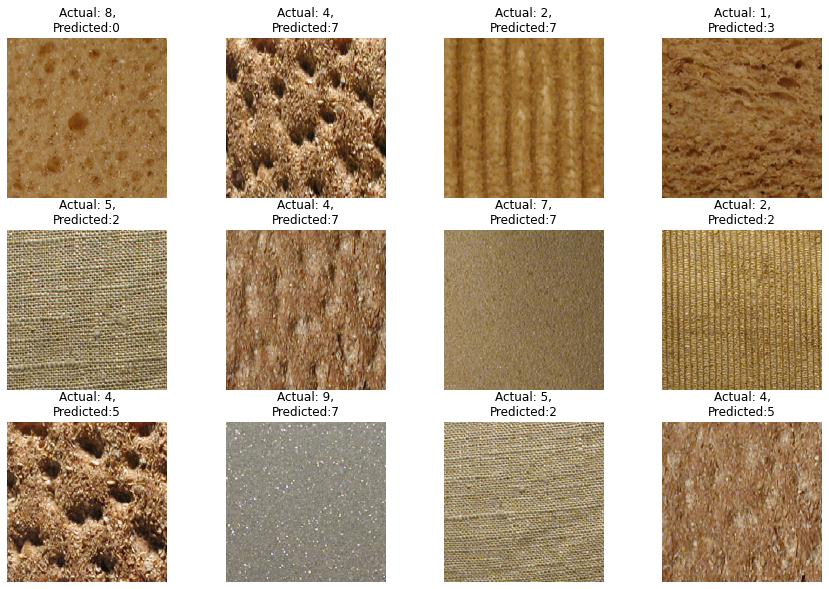

In [45]:
plt.figure(figsize=(15,10))
for i in range(12):
    plt.subplot(3,4,i+1)
    valid_images,valid_labels = testing_data[i]
    plt.imshow(valid_images[0])
    actual = np.argmax(valid_labels)
    predictions = np.argmax(pred[i])
    plt.title(f"Actual: {actual},\nPredicted:{predictions}")
    plt.axis("off")

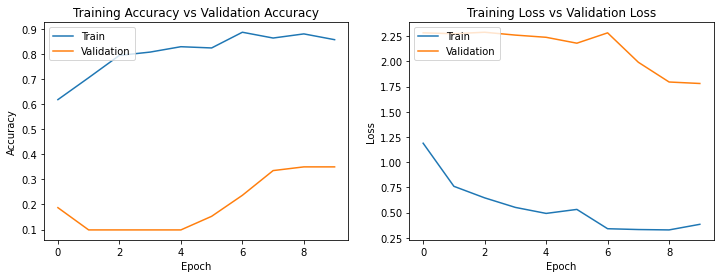

In [42]:
fig , ax = plt.subplots(1,2)
fig.set_size_inches(12,4)

ax[0].plot(history.history['acc'])
ax[0].plot(history.history['val_acc'])
ax[0].set_title('Training Accuracy vs Validation Accuracy')
ax[0].set_ylabel('Accuracy')
ax[0].set_xlabel('Epoch')
ax[0].legend(['Train', 'Validation'], loc='upper left')

ax[1].plot(history.history['loss'])
ax[1].plot(history.history['val_loss'])
ax[1].set_title('Training Loss vs Validation Loss')
ax[1].set_ylabel('Loss')
ax[1].set_xlabel('Epoch')
ax[1].legend(['Train', 'Validation'], loc='upper left')